# Computing the dense optical flow between two frames

The optical flow is a family of algorithms which addresses the issue of finding the movement of points between two images (usually subsequent frames in a video). Dense optical flow algorithms find movements of all pixels in a frame. The dense optical flow can be used to find objects moving in a sequence of frames, or to detect camera movements. In this recipe, we will find out how to compute and display the dense optical flow in several ways, using OpenCV functionality.

To compute the optical flow, you need two images (which are usually consecutive frames from a video). Both methods that we've used in the code accept `8-bit` grayscale images as frames.

First, let's discuss the usage of the `cv2.calcOpticalFlowFarneback` function. It takes the following parameters, the previous frame, current frame, initialization for optical flow, scale between the pyramid's layers, number of layers in the pyramid, size of the window for the smoothing step, number of iterations, number of neighborhood pixels to find the polynom's parameters, standard deviation of Gaussian (which is used to smooth the polynom's derivatives), and finally, flags.

The last parameter manages the optical flow process, if `cv2.OPTFLOW_FARNEBACK_GAUSSIAN` is used, then input images are blurred with a Gaussian filter and the size of the window equals the value of the sixth argument; if `cv2.OPTFLOW_USE_INITIAL_FLOW` is used, then the algorithm considers the third argument as an initialization of optical flow—which is used, then, we handle frames till a video and have the optical flow computed beforehand. Flags can be combined using a logical `OR` operation.

Referring to the remaining arguments, the values used in the code are considered good for the algorithm, so it's possible to use them as-is; in most of the cases, they work well.

Applying the `Dual TV L1` optical flow algorithm is different. We need to create an instance of the `cv2.DualTVL1OpticalFlow` class by calling the `cv2.createOptFlow_DualTVL1` function. Then, we can get the optical flow by calling the `calc` function of the created instance. This function takes the previous frame, current frame, and optical flow initialization as arguments.

To get or set the values of algorithm parameters, you need to use class functions. As seen previously, most of the parameters are initialized with values that work well in many cases. The one that you need to change is the parameter of optical flow initialization. It can be done with the `setUseInitialFlow` function.

Both functions return the optical flow as a result of computation. It is presented as a 2-channel matrix of floating-point values, and has the same spatial size as the input frames. The first channel consists of the `X` (horizontal) projection of the movement vector for each frame pixel; the second channel is for the `Y` (vertical) projection of the movement vector. So, we are able to know the direction of the movement for each pixel, as well as the magnitude.

`Dual TV L1` gives the optical flow without holes, compared to `Farneback`'s algorithm. But it costs computing time, the `Dual TV L1` algorimth is much slower.

In [1]:
# Import the module
import time
import imutils

# Import all of the necessary modules
import cv2
import matplotlib.pyplot as plt
import numpy as np

%matplotlib auto
%pylab inline


def print_image(header,name,np_arr,start_First=0, end_First=1, start_Second=0, end_Second=2):
    print("------  {0:-<25}    Shape{1} {2}: {3:}".format(header, np_arr.shape, name, str(np_arr.dtype)) )
    shapes = np_arr.shape #print(shapes)
    if shapes[0] < end_First:
        end_First = shapes[0]
    if shapes[1] < end_Second:
        end_Second = shapes[1]
    if len(shapes)==3:
        for i in range (start_First,end_First):
            print("[", end=" ")
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')
    if len(shapes)==2:
        for i in range (start_First,end_First):
            print("[", end=" ")
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')
def plt_view_image(plt,list_images,figsize=(15,6), axis="off", cmap='gray'):
    #%pylab inline
    plt.figure(figsize=figsize)
    n = len(list_images)  #; print(n)
    plot_number = 1
    for name, img in list_images:
        plt.subplot(1,n,plot_number)
        plt.axis(axis)
        plt.title(name)
        if cmap =='gray':
            plt.imshow(img,cmap='gray' )
        else:
            plt.imshow(img )
        plot_number = plot_number + 1
    plt.show()
#help("modules")   
import sys             
print('\n'.join(sys.path))
#pip list"

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
D:\HTML_DOC\Program\opencv\Packt\S04\env
C:\Program Files\Python38\python38.zip
C:\Program Files\Python38\DLLs
C:\Program Files\Python38\lib
C:\Program Files\Python38
d:\html_doc\program\opencv\packt\s04\env

d:\html_doc\program\opencv\packt\s04\env\lib\site-packages
d:\html_doc\program\opencv\packt\s04\env\lib\site-packages\pip-20.0.2-py3.8.egg
d:\html_doc\program\opencv\packt\s04\env\lib\site-packages\win32
d:\html_doc\program\opencv\packt\s04\env\lib\site-packages\win32\lib
d:\html_doc\program\opencv\packt\s04\env\lib\site-packages\Pythonwin
d:\html_doc\program\opencv\packt\s04\env\lib\site-packages\IPython\extensions
C:\Users\polit\.ipython


In [2]:
# Define the function to display the optical flow
#def display_flow(img, flow, stride=40):
def display_flow(img, flow,  image_frames, count_i, stride=40):
    for index in np.ndindex(flow[::stride, ::stride].shape[:2]):
        pt1 = tuple(i*stride for i in index)
        delta = flow[pt1].astype(np.int32)[::-1]
        pt2 = tuple(pt1 + 10*delta)
        if 2 <= cv2.norm(delta) <= 10:
            cv2.arrowedLine(img, pt1[::-1], pt2[::-1], (0,0,255), 5, cv2.LINE_AA, 0, 0.4)
        
    norm_opt_flow = np.linalg.norm(flow, axis=2)
    norm_opt_flow = cv2.normalize(norm_opt_flow, None, 0, 1, cv2.NORM_MINMAX)
    
    
    cv2.imshow('optical flow', img)
    cv2.imshow('optical flow magnitude', norm_opt_flow)
    #####################################################
    if count_i ==1:
        image_frames.append(["frame:{}".format(count_i),img[:,:,[2,1,0]]])
        image_frames.append(["norm_opt_flow:{}".format(count_i),norm_opt_flow])
    if count_i % 250 == 0:
        image_frames.append(["frame:{}".format(count_i),img[:,:,[2,1,0]]])
        image_frames.append(["norm_opt_flow:{}".format(count_i),norm_opt_flow])
    #####################################################
    
    k = cv2.waitKey(1)
    
    if k == 27:
        return 1
    else:
        return 0

# [То, что вы хотели знать про Optical flow(оптический поток), но стеснялись спросить](https://habr.com/en/post/201406/)

Обычный __Лукас-Канаде__ хорошо определяет маленькие сдвиги, такие, в рамках которых картинка похожа на свое линейное приближение. Чтобы с этим побороться, воспользуемся стандартным приемом CV – multi-scaling'ом: построим «пирамиду» изображений разного масштаба (почти всегда берется масштабирование в 2 раза по каждой оси, так проще считать) и пройдем по ним оптическим потоком от меньшего изображения к большему, тогда детектированный маленький сдвиг на маленьком изображении будет соответствовать большому сдвигу на большом изображении. На самом маленьком изображении мы обнаруживаем сдвиг не более 1-2 пикселей, а переходя от меньшего масштаба к большему, мы пользуемся результатом с предыдущего шага и уточняем значения сдвига. Собственно, в OpenCV его и реализует функция __calcOptFlowPyrLK__. Использование этого пирамидального алгоритма позволяет нам не заморачиваться вычислением линейной аппроксимации по многим точкам: проще взять больше уровней пирамиды, а на каждом уровне брать довольно грубое приближение этой функции. Поэтому в OpenCV и идет расчет всего по двум соседним точкам. И поэтому применительно к этой реализации алгоритма наши умозаключения про преимущество аппроксимирующей функции перед производной оказались бесполезными: для такого количества опорных точек производная и есть лучшая аппроксимирующая функция.

Алгоритм Фарнебака реализован в OpenCV в виде функции calcOpticalFlowFarneback. Данная реализация использует плотный поток, поэтому считает сдвиг для каждой точки и нет никакой необходимости использовать дополнительные детекторы точек, как в случае с
алгоритмом Лукаса-Канаде. Входные и выходные параметры данной функции: два изображения (или кадра), следующие друг за другом, выходной поток в формате двухканальной матрицы (матрица векторов)

Этот алгоритм менее стабилен и плохо работает на больших сдвигах. Время работы
алгоритма-около 600 мс. для изображения 512х512 пикселей (тестирование проводилось на
процессоре Intelcore i7 950).

------  prev_frame---------------    Shape(540, 960) prev_frame: uint8
[ 222 222 223 223 223 223 224 ]
cv2.calcOpticalFlowFarneback  ==  14


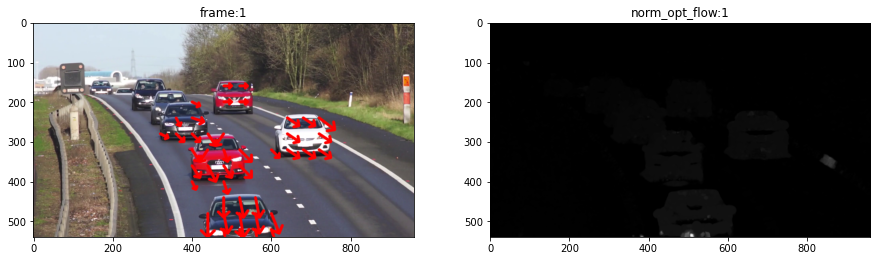

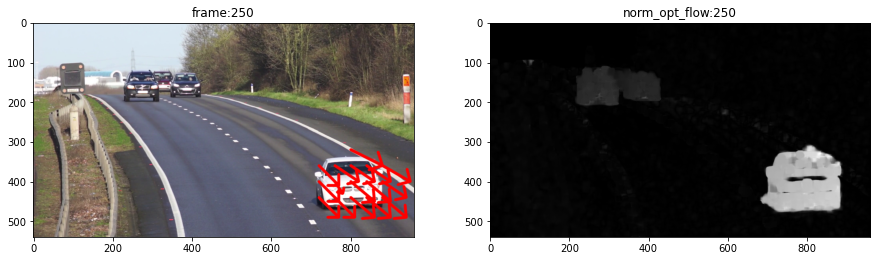

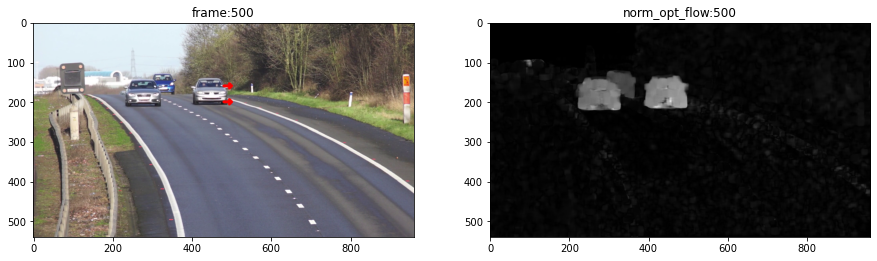

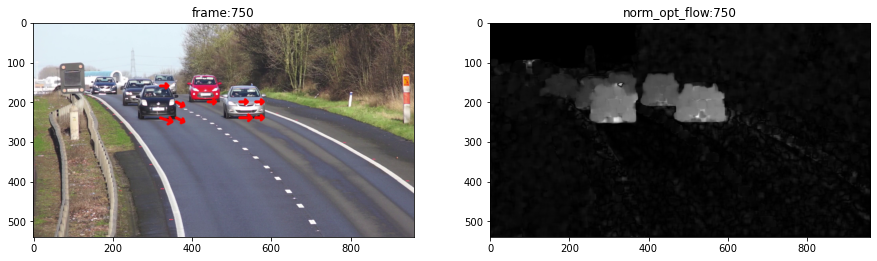

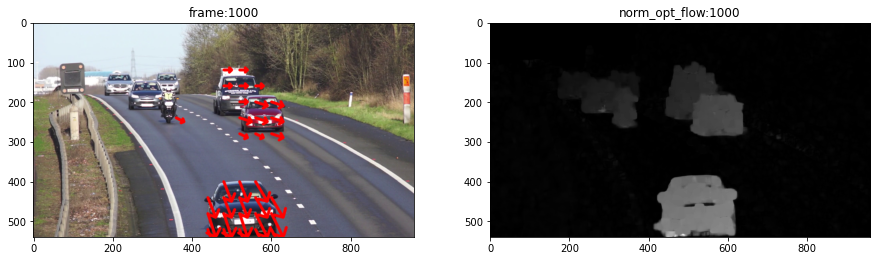

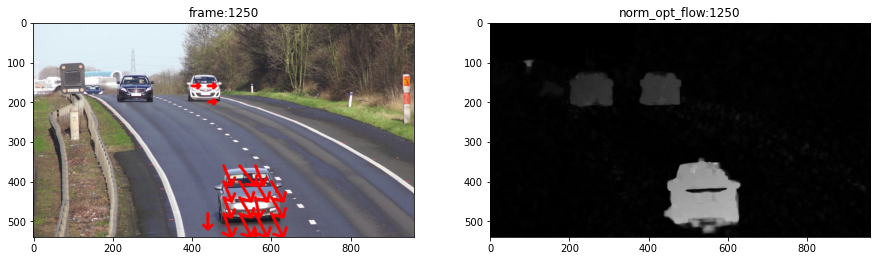

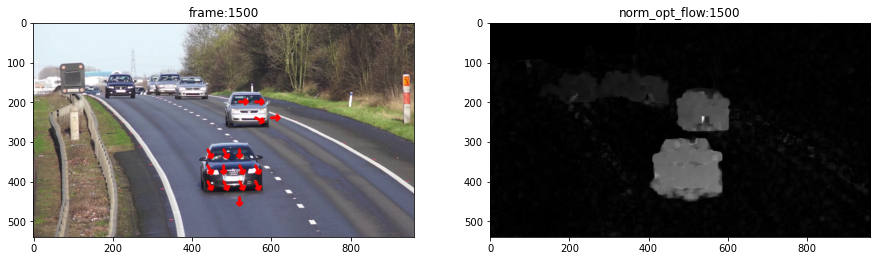

In [3]:
#cv2.calcOpticalFlowFarneback(prev, next, pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, flags[, flow]) -> flow
#  prev - 1-ое 8-ми битное изображение.
#  next - 2-ое входное изображение такого же размера и типа, что и первое.
#  flow -Вычисленное изображение потока, имеет тот же размер, что и prevImg и тип CV_32FC2.
#  pyr_Scale - Определяет масштаб изображения. pyrScale=0.5 означает классическую пирамиду, где каждый
#              следующий уровень вдвое меньше, чем предыдущий.
#  levels - Количество уровней пирамиды, включая начальное изображение. Levels=1 означает, что
#           используется только первоначальное изображение.
#  winsize - Средний размер окна. Большие значения увеличивают ошибкоустойчивость алгоритма, но
#            выдают более размытую область движения.
#  iterations - Количество итераций алгоритма на каждом уровне пирамиды.
#  poly_N - Размер окрестностей пикселей для нахождения расширенного полиномиала. Большие значения дают сглаженные края.
#  poly_Sigma - Стандартное отклонение Гауссиана, которое используется для сглаживания в polyN. Для
#               poly_N=5 Вы можете устанавливать poly_Sigma=1.1, для poly_N=7, хорошее значение было бы poly_Sigma=1.5
#  flags - Флаги, могут комбинацией из следующих:
#          OPTFLOW_USE_INITIAL_FLOW   – использует входной поток, как начальное приближение потока.
#          OPTFLOW_FARNEBACK_GAUSSIAN – использует Гауссиан размера winsize* winsize вместо блокового фильтра. 
#                                       Работает медленнее, но точнее

# Open the video and grab its first frame. 
cap = cv2.VideoCapture("../data/traffic.mp4")
status_cap, prev_frame = cap.read()

# Next, read the frames one-by-one
# and compute the dense optical flow using Gunnar Farneback's algorithm. 
prev_frame = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
prev_frame = cv2.resize(prev_frame, (0,0), None, 0.5, 0.5)
init_flow = True

print_image('prev_frame','prev_frame',prev_frame,0,1,0,7)
i = 0
image_frames =[]

# Then, display the results
while True:
    status_cap, frame = cap.read()
    if not status_cap:
        break
    frame = cv2.resize(frame, (0,0), None, 0.5, 0.5)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    if init_flow:
        #Shape: (540, 960, 2)   Data type: float32
        opt_flow = cv2.calcOpticalFlowFarneback(prev_frame, gray, None, 
                                                0.5, 5, 13, 10, 5, 1.1, 
                                                cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
        init_flow = False
    else:
        opt_flow = cv2.calcOpticalFlowFarneback(prev_frame, gray, opt_flow, 
                                                0.5, 5, 13, 10, 5, 1.1, 
                                                cv2.OPTFLOW_USE_INITIAL_FLOW)
    
    prev_frame = np.copy(gray) #Shape: (540, 960)   Data type: uint8
    
    i +=1
    #if display_flow(frame, opt_flow):
    if display_flow(frame, opt_flow, image_frames, i):
        break;
    
cv2.destroyAllWindows()

print("cv2.calcOpticalFlowFarneback  == ", len(image_frames))
k =2
for jki in range(0,len(image_frames),k):
    plt_view_image(plt,image_frames[jki:jki+k], figsize=(15,8), axis='on', cmap='gray')

<class 'cv2.optflow_DualTVL1OpticalFlow'>
------  prev_frame---------------    Shape(540, 960) prev_frame: uint8
[ 222 222 223 223 223 223 224 ]
cv2.optflow.createOptFlow_DualTVL1  ==  14


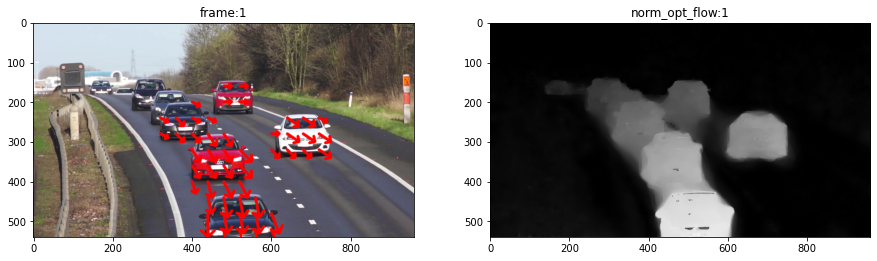

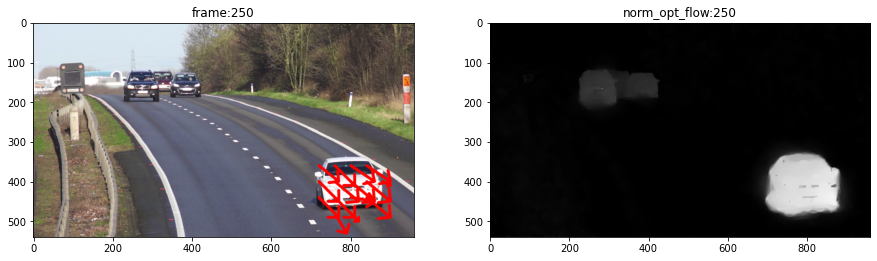

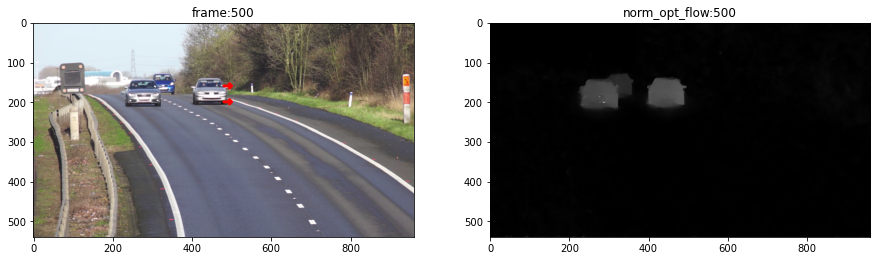

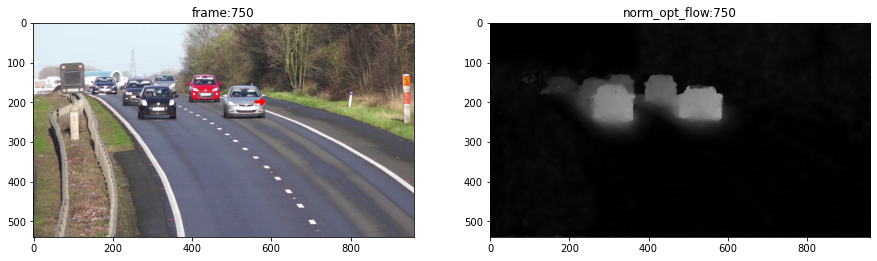

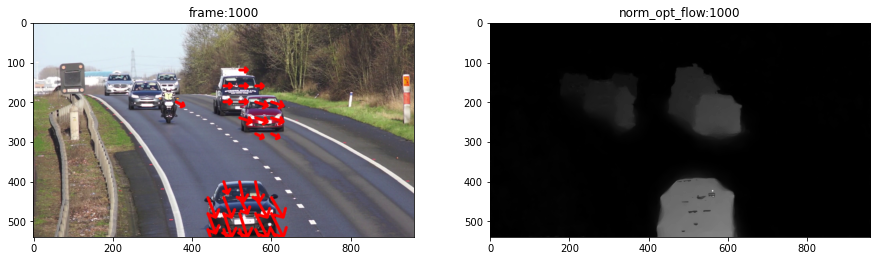

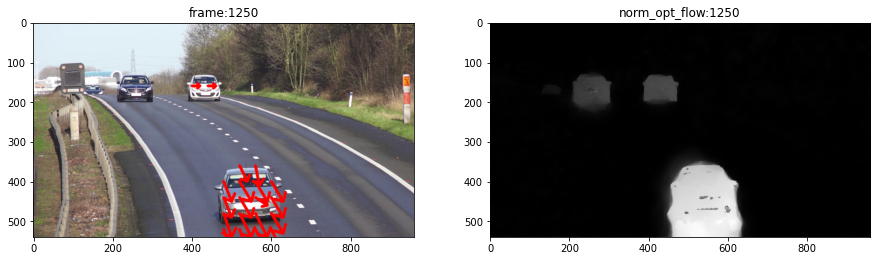

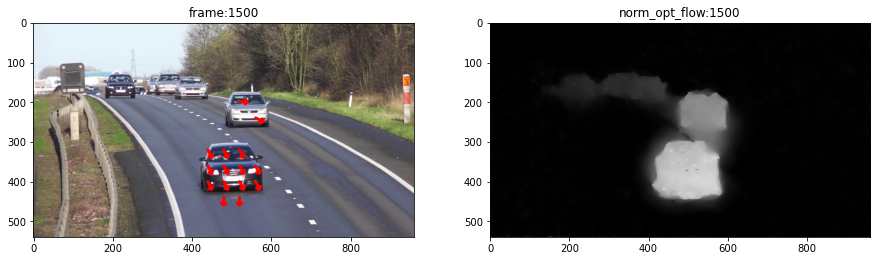

In [4]:
# Set the position of the video capture to the beginning, 
# and read the first frame. 
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
status_cap, prev_frame = cap.read()

prev_frame = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
prev_frame = cv2.resize(prev_frame, (0,0), None, 0.5, 0.5)
#init_flow = True
#Shape: (540, 960)   Data type: uint8
#print_image('prev_frame','prev_frame',prev_frame,0,1,0,10)

# Create an instance of a class which computes the Dual TV L1 optical flow.
#flow_DualTVL1 = cv2.createOptFlow_DualTVL1() # opencv 3
flow_DualTVL1 = cv2.optflow.createOptFlow_DualTVL1() # opencv 4

print(type(flow_DualTVL1))
print_image('prev_frame','prev_frame',prev_frame,0,1,0,7)
i = 0
image_frames =[]


# Then, read the frames one-by-one and get the optical flow for each subsequent pair of frames 
# display the results
while True:
    status_cap, frame = cap.read()
    if not status_cap:
        break
        
    frame = cv2.resize(frame, (0,0), None, 0.5, 0.5)
    #print_image('frame','frame',frame,0,1,0,10)
    #Shape: (540, 960, 3)   Data type: uint8
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    if not flow_DualTVL1.getUseInitialFlow(): 
        #print_image('opt_flow','opt_flow',opt_flow,0,1,0,10)
        #Shape: (540, 960, 2)   Data type: float32
        opt_flow = flow_DualTVL1.calc(prev_frame, gray, None) 
    else:
        opt_flow = flow_DualTVL1.calc(prev_frame, gray, opt_flow)
           
    #print_image('prev_frame','prev_frame',prev_frame,0,1,0,10)
    #Shape: (540, 960)   Data type: uint8
    prev_frame = np.copy(gray)

    i +=1 
    #if display_flow(frame, opt_flow):
    if display_flow(frame, opt_flow, image_frames, i):
        break;
    
cv2.destroyAllWindows()

print("cv2.optflow.createOptFlow_DualTVL1  == ", len(image_frames))
k =2
for jki in range(0,len(image_frames),k):
    plt_view_image(plt,image_frames[jki:jki+k], figsize=(15,8), axis='on', cmap='gray')